# 0. Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import os
import cv2

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *

train_dir = 'data/train'
validation_dir = 'data/valid'
test_dir = 'data/test'



train_datagen = ImageDataGenerator(
      rescale=1./255,
 #     rotation_range=90,
#      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=256,
        shuffle = True,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=64,
        shuffle = True,
        class_mode='binary')

Found 10374 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.


# 1. Modeling

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import *

In [31]:
net = MobileNet(weights='imagenet',include_top=False,pooling='max')

/Users/gimjuho/opt/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [32]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
model = Sequential()
model.add(net)
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 3,208,001
Non-trainable params: 21,888
_________________________________________________________________


In [33]:
net.trainable =False

In [34]:
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [35]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/30
10/10 [==============================] - 69s 7s/step - loss: 1.9644 - acc: 0.5037 - val_loss: 1.3601 - val_acc: 0.5031
Epoch 2/30
10/10 [==============================] - 73s 7s/step - loss: 1.3567 - acc: 0.5199 - val_loss: 1.3272 - val_acc: 0.5391
Epoch 3/30
10/10 [==============================] - 72s 7s/step - loss: 1.1431 - acc: 0.5602 - val_loss: 1.4813 - val_acc: 0.5516
Epoch 4/30
10/10 [==============================] - 77s 8s/step - loss: 1.1172 - acc: 0.5754 - val_loss: 1.3162 - val_acc: 0.5703
Epoch 5/30
10/10 [==============================] - 73s 7s/step - loss: 1.0603 - acc: 0.5895 - val_loss: 1.3063 - val_acc: 0.5797
Epoch 6/30
10/10 [==============================] - 73s 7s/step - loss: 0.9659 - acc: 0.6083 - val_loss: 1.3134 - val_acc: 0.5953
Epoch 7/30
10/10 [==============================] - 72s 7s/step - loss: 0.9648 - acc: 0.6184 - val_loss: 1.2689 - val_acc: 0.604

KeyboardInterrupt: 

In [ ]:
def generate_grad_cam(img_tensor, model, class_index, activation_layer):
    """
    params:
    -------
    img_tensor: resnet50 모델의 이미지 전처리를 통한 image tensor
    model: pretrained resnet50 모델 (include_top=True)
    class_index: 이미지넷 정답 레이블
    activation_layer: 시각화하려는 레이어 이름

    return:
    grad_cam: grad_cam 히트맵
    """
    inp = model.input
    y_c = model.output.op.inputs[0][0, class_index]
    A_k = model.get_layer(activation_layer).output
    
    ## 이미지 텐서를 입력해서
    ## 해당 액티베이션 레이어의 아웃풋(a_k)과
    ## 소프트맥스 함수 인풋의 a_k에 대한 gradient를 구한다.
    get_output = K.function([inp], [A_k, K.gradients(y_c, A_k)[0], model.output])
    [conv_output, grad_val, model_output] = get_output([img_tensor])

    ## 배치 사이즈가 1이므로 배치 차원을 없앤다.
    conv_output = conv_output[0]
    grad_val = grad_val[0]
    
    ## 구한 gradient를 픽셀 가로세로로 평균내서 a^c_k를 구한다.
    weights = np.mean(grad_val, axis=(0, 1))
    
    ## 추출한 conv_output에 weight를 곱하고 합하여 grad_cam을 얻는다.
    grad_cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam += w * conv_output[:, :, k]
    
    grad_cam = cv2.resize(grad_cam, (224, 224))

    ## ReLU를 씌워 음수를 0으로 만든다.
    grad_cam = np.maximum(grad_cam, 0)

    grad_cam = grad_cam / grad_cam.max()
    return grad_cam

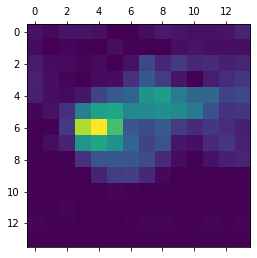

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [ ]:
import cv2
img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('elephant_cam.jpg', superimposed_img)